<a href="https://colab.research.google.com/github/o-fugi/FURSPColexification/blob/main/code/PCA_on_Classified_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ColabFiles/

Mounted at /content/drive/
/content/drive/MyDrive/ColabFiles


In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from functools import reduce

In [ ]:
# install sentence-trasnformers
%%capture
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('whaleloops/phrase-bert')

### calculate PCA

In [ ]:
shift_class_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/classified_shifts.csv', encoding='ISO-8859-1')

In [234]:
# remove NaN rows
shift_class_df['Bleached sense'] = shift_class_df['Bleached sense'].fillna('NaN')
shift_class_df = shift_class_df[shift_class_df['Bleached sense']!='NaN']

# remove completely duplicated rows
shift_class_df = shift_class_df[~shift_class_df.duplicated()]

# these seem a little outside of our area of study 
# shift_class_df = shift_class_df[shift_class_df['Type of change']!= 'grammaticalization']
# shift_class_df = shift_class_df[shift_class_df['Type of change']!= 'synaesthesia']

allowed_types = ['metaphor', 'narrowing', 'pejoration', 'broadening', 'metonymy', 'amelioration', 'antonymy', 'analogy', 'broadening, metaphor', 'pejoration, homophony']
shift_class_df = shift_class_df[shift_class_df['Type of change'].isin(allowed_types)]

In [236]:
# get rid of punctuation in the senses

def cleanString(s):
  s = s.lower()
  s = s.replace("'", "")
  s = s.replace(",", "")
  s = s.replace(";", "")
  s = s.lower()
  return s

shift_class_df['meaning1'] = shift_class_df['Original sense'].apply(cleanString)
shift_class_df['meaning2'] = shift_class_df['Bleached sense'].apply(cleanString)

In [237]:
# dictionary for concreteness and embeddings
vec_dic = {} # This will be a dictionary that easily allows us to access the embedding for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings or concreteness values

for i in range(len(shift_class_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = shift_class_df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  try:   
    if x not in vec_dic:
      xvec = np.array(model.encode(x))
      vec_dic[x] = xvec
  except:
    error_senses.add(x)

  try:  
    if y not in vec_dic:
      yvec = np.array(model.encode(y))
      vec_dic[y] = yvec
  except: 
    error_senses.add(y)

error_senses = list(error_senses) # List of all senses that could not be converted to embeddings. Should be empty right now with phrase BERT
senses = list(vec_dic.keys()) # List of all concepts

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses.

In [238]:
# create dataframe with a pair of embeddings for each shift

all_vars_df = pd.DataFrame()
all_vars_df['word'] = shift_class_df['Word']
all_vars_df['meaning1'] = shift_class_df['meaning1']
all_vars_df['meaning2'] = shift_class_df['meaning2']
all_vars_df['type'] = shift_class_df['Type of change']

# all_vars_df['concat_meaning1'] = all_vars_df['word'] + " " + all_vars_df['meaning1']
# all_vars_df['concat_meaning2'] = all_vars_df['word'] + " " + all_vars_df['meaning2']

vec_df = pd.DataFrame.from_dict(vec_dic, orient='index').reset_index().rename(columns={'index':'Word'})
vec_meaning_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [all_vars_df, vec_df])
vec_meaning_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [vec_meaning_df, vec_df])

In [239]:
# create dataframe with one difference embedding for each shift

vec_meaning_df_2 = pd.DataFrame()

for i in range(len(model.encode('yikes'))):
  vec_meaning_df_2[i] = vec_meaning_df[str(i) + "_y"] - vec_meaning_df[str(i) + "_x"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [240]:
# get values from df
x = vec_meaning_df_2.values
x_scale = x # StandardScaler().fit_transform(x)

In [241]:
# do PCA
pca = PCA(n_components=50)
components = pca.fit_transform(x_scale)
components_df = pd.DataFrame(data = components)#.rename(columns={0:'PC_1' , 1:'PC_2', 2:"PC_3", 3:'PC_4'})

all_vars_df.reset_index(inplace = True)

# merge back into word data
df = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True), [all_vars_df, components_df])

#### sanity check

In [245]:
df[['word', 'meaning1', 'meaning2', 'type', 0, 1]].sort_values(by=0, ascending=False).tail(20)

,word,meaning1,meaning2,type,0,1
40,knight,boy,military title,amelioration,-4.328202,-7.106907
123,back,behind,follow support,metonymy,-4.431248,-7.614429
22,labor,work a task,childbirth,narrowing,-4.445207,7.343445
18,in,within the bounds of a space,temporal,metaphor,-4.488061,3.936552
19,within,within the bounds of a space,temporal,metaphor,-4.488061,3.936552
29,satellite,attendant upon person of importance,orbiting object,metaphor,-4.700023,4.402725
119,hour,60 minutes,period of time,metonymy,-4.836022,-1.921966
106,fair,pleasant beautiful,average mediocre,pejoration,-4.864284,-2.266391
20,crane,large bird,machine in construction,metaphor,-4.999120,-3.512316
32,arrive,to reach a shore,to reach generally,broadening,-5.333942,-5.193654


### visualizations

#### scatterplot

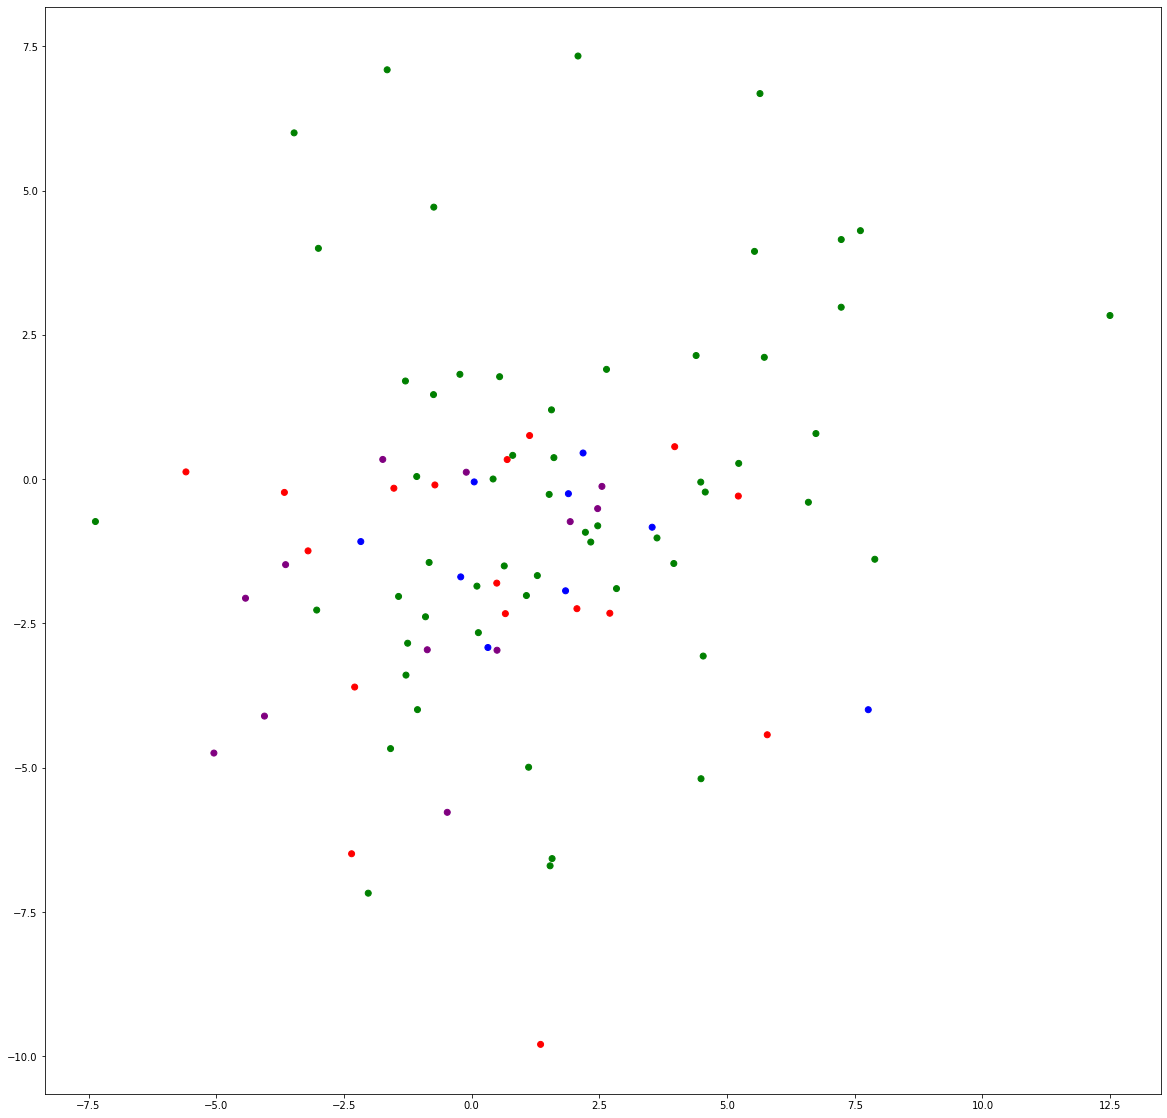

In [ ]:
# scatterplot

# filter, if you want colors
filtered_df = df[df['type'].isin(['bleaching', 'narrowing', 'pejoration', 'broadening'])]
colors = {'bleaching':'red', 'narrowing':'blue', 'pejoration':'green', 'broadening':'purple'}

plt.scatter(filtered_df[1], filtered_df[0], c=filtered_df.type.map(colors))

#### vector field

In [253]:
# get source embeddings transformed to PCA for vector fields

transform_vec_dic = {}

for i in vec_dic:
  #transform_vec_dic[i]  = list(pca.transform(scaler.transform(vec_dic[i].reshape(1, -1)))[0])
  transform_vec_dic[i]  = list(pca.transform(vec_dic[i].reshape(1, -1))[0])

transform_vec_df = pd.DataFrame.from_dict(transform_vec_dic, orient='index').reset_index().rename(columns={'index':'Word'})

vector_field_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [df, transform_vec_df]) #x is change, y is source

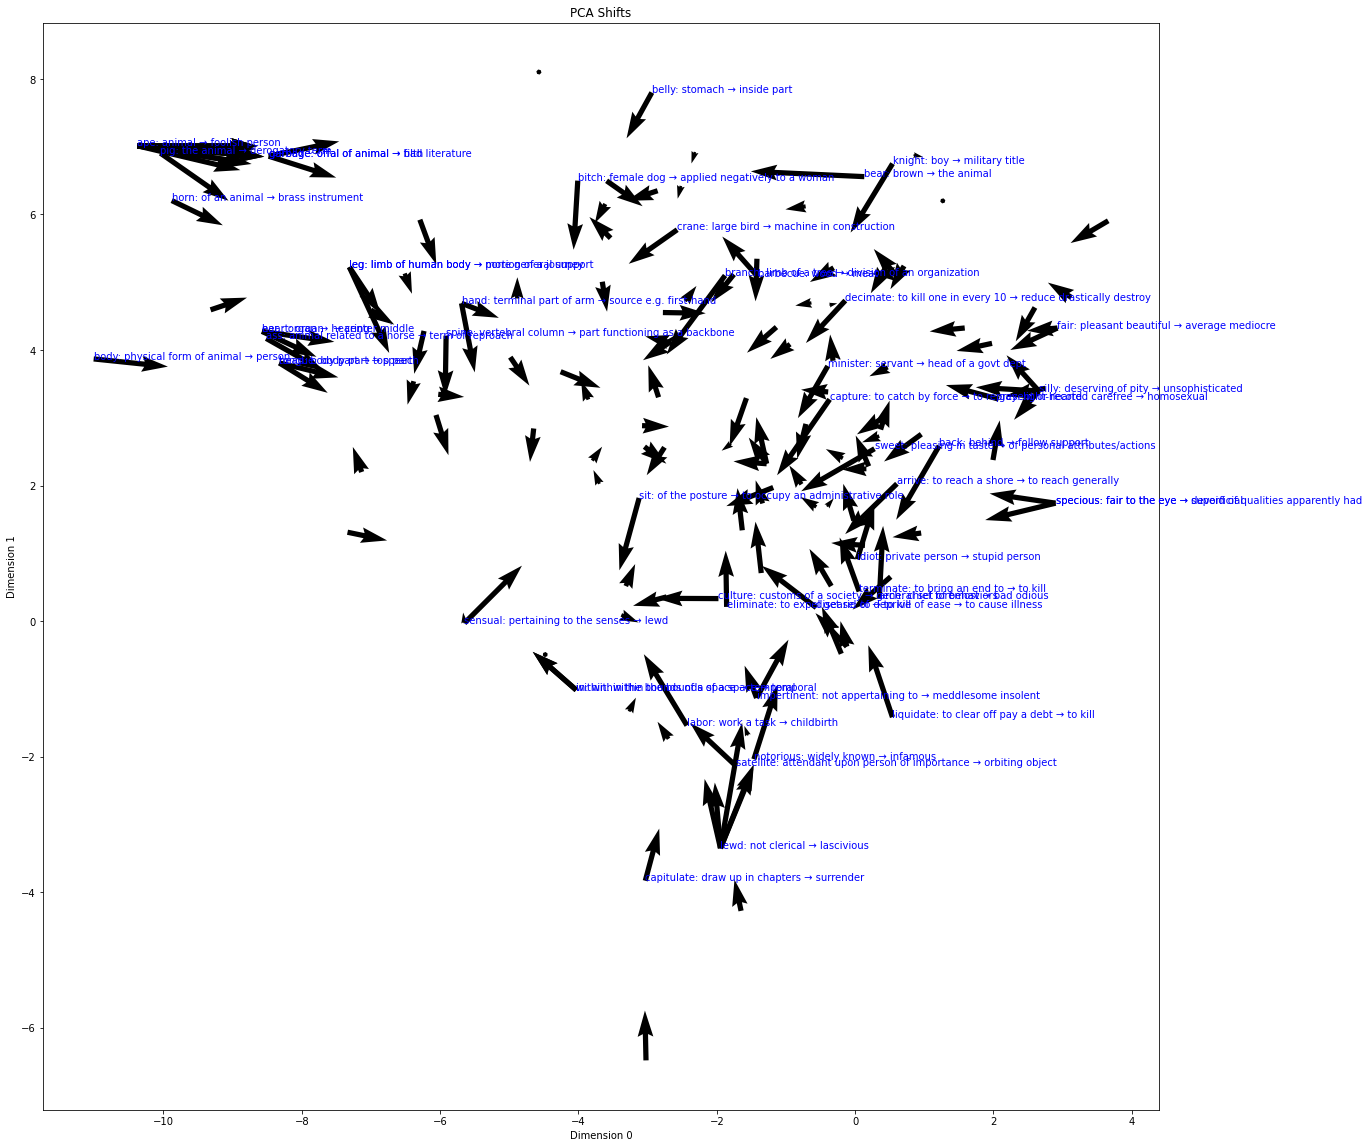

In [276]:
# vector field of vectors by principal components

# which dimensions are we plotting 
x = 0
y = 1

plt.xlabel("Dimension " + str(x))# + " pejoration")
plt.ylabel("Dimension " + str(y))# + "ameloration")

# 0 is the x-dimension and 1 is the y-dimension
# y is the source, x is the difference, i know this is terrible
plt.title("PCA Shifts")
plt.quiver(vector_field_df['0_y'], vector_field_df['1_y'], vector_field_df['0_x'], vector_field_df['1_x'])#, color=df.type.map(colors))

# label a couple of interesting points 
def getLabel(row):
  return (row['word'] + ": " + row['meaning1'] + " → " + row['meaning2'], (row['0_y'], row['1_y']))

labels = []

# row_min_x = vector_field_df.sort_values(by='0_y').iloc[0]
# row_max_x = vector_field_df.sort_values(by='0_y', ascending=False).iloc[0]
# row_min_y = vector_field_df.sort_values(by='1_y').iloc[0]
# row_max_y = vector_field_df.sort_values(by='1_y', ascending=False).iloc[0]

# labels.append(getLabel(row_min_x))
# labels.append(getLabel(row_max_x))
# labels.append(getLabel(row_min_y))
# labels.append(getLabel(row_max_y))

# # some randomly chosen points for illustration
# labels.append(getLabel(vector_field_df.iloc[82]))
# labels.append(getLabel(vector_field_df.iloc[194]))
# labels.append(getLabel(vector_field_df.iloc[73]))
# labels.append(getLabel(vector_field_df.iloc[200]))
# labels.append(getLabel(vector_field_df.iloc[57]))
# labels.append(getLabel(vector_field_df.iloc[198]))

# label the longest vectors
vector_field_df['change_len'] = np.linalg.norm(vector_field_df[['0_x','1_x']].values,axis=1)
sorted_vec_df = vector_field_df.sort_values(by='change_len', ascending=False)
sorted_vec_df = sorted_vec_df.drop(range(56, 65)) # duplicates for "animal"
sorted_vec_df = sorted_vec_df.drop(range(146, 150)) # duplicates for "not clerical"

for i in range(50):
  row = sorted_vec_df.iloc[i]
  labels.append(getLabel(row))

for label in labels:
    plt.annotate(label[0], label[1], color='b')

#### variance plot

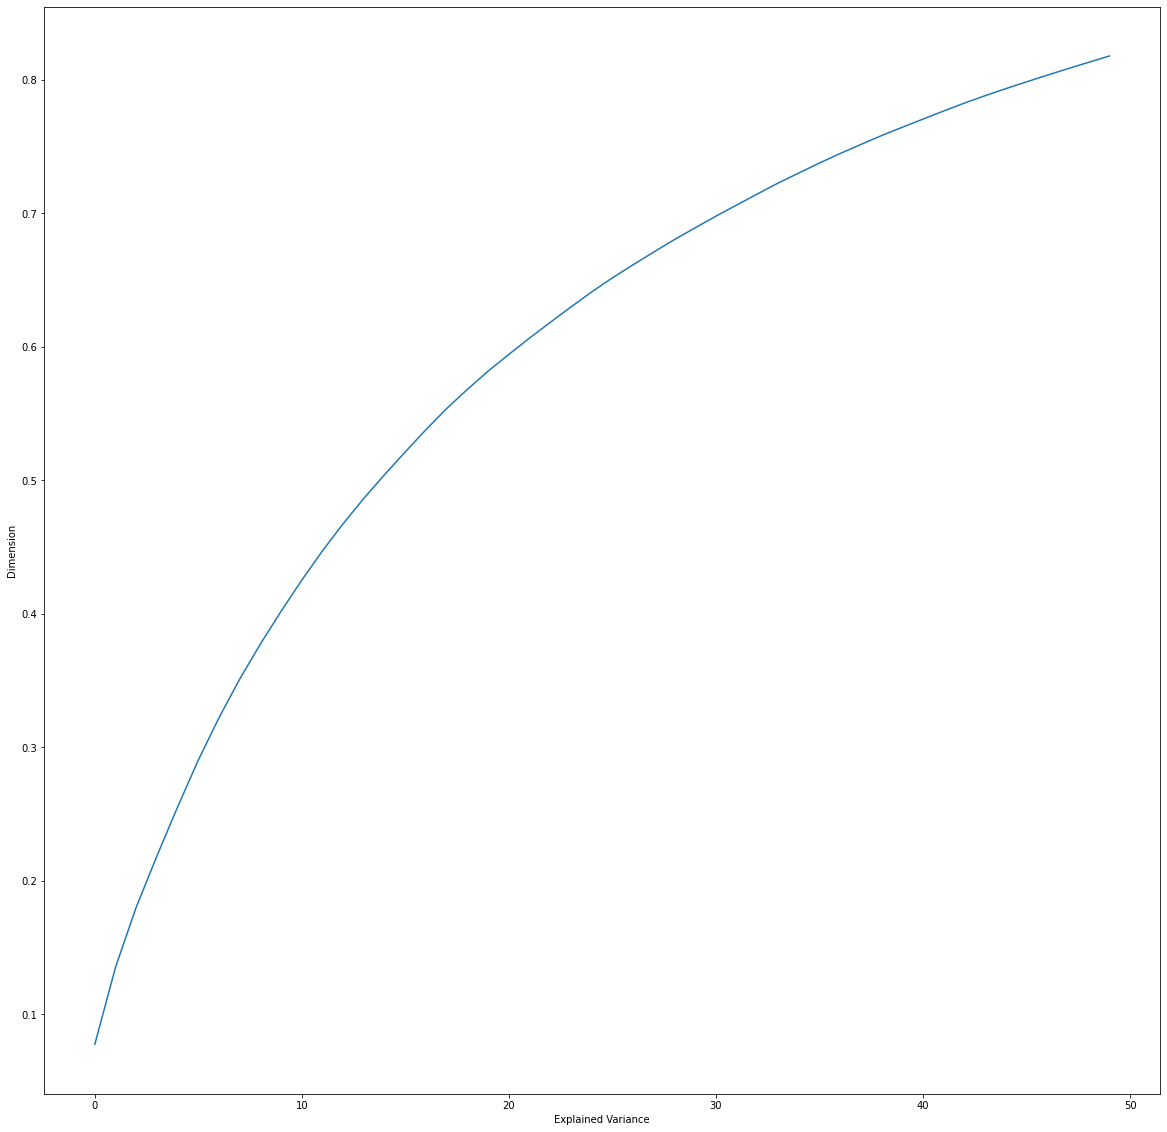

In [ ]:
# explained variance plot

plt.xlabel("Explained Variance")
plt.ylabel("Dimension")
plt.plot(np.cumsum(pca.explained_variance_ratio_))

### try tsne on classification

In [ ]:
# first, reduce with PCA

x_scale = df[range(50)].values

In [ ]:
# fewer shifts cause it kinda takes a while
subsample_idc = range(len(x_scale)) # np.random.choice(x_scale.shape[0], 1000, replace=False)
x_scale_sample = x_scale[subsample_idc]

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity=100)
tsne_result = tsne.fit_transform(x_scale_sample)

tsne_df = pd.DataFrame(data = tsne_result)

# merge back into word data
tsne_df = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True), [all_vars_df, tsne_df])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


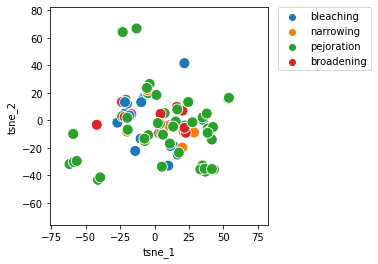

In [ ]:
#@title 2

tsne_result_df = pd.DataFrame({'tsne_1': tsne_df[0], 'tsne_2': tsne_df[1], 'label': tsne_df['type']})
tsne_result_df = tsne_result_df[tsne_result_df['label'].isin(['bleaching', 'narrowing', 'pejoration', 'broadening'])]
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

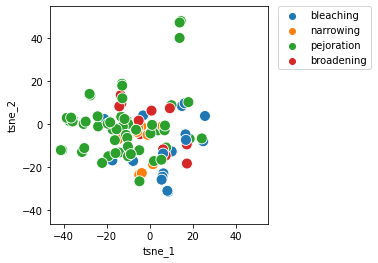

In [ ]:
#@title 5

import seaborn as sns

tsne_result_df = pd.DataFrame({'tsne_1': tsne_df[0], 'tsne_2': tsne_df[1], 'label': tsne_df['type']})
tsne_result_df = tsne_result_df[tsne_result_df['label'].isin(['bleaching', 'narrowing', 'pejoration', 'broadening'])]
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

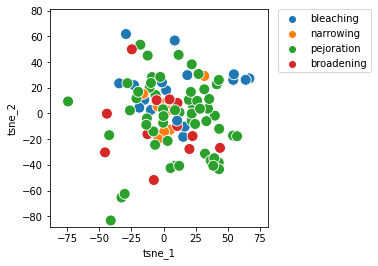

In [ ]:
#@title 20 

tsne_result_df = pd.DataFrame({'tsne_1': tsne_df[0], 'tsne_2': tsne_df[1], 'label': tsne_df['type']})
tsne_result_df = tsne_result_df[tsne_result_df['label'].isin(['bleaching', 'narrowing', 'pejoration', 'broadening'])]
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

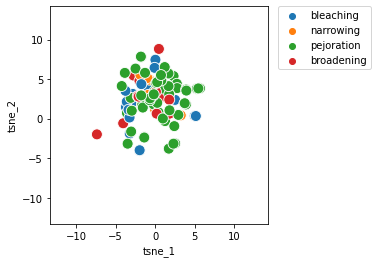

In [ ]:
#@title 30

tsne_result_df = pd.DataFrame({'tsne_1': tsne_df[0], 'tsne_2': tsne_df[1], 'label': tsne_df['type']})
tsne_result_df = tsne_result_df[tsne_result_df['label'].isin(['bleaching', 'narrowing', 'pejoration', 'broadening'])]
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

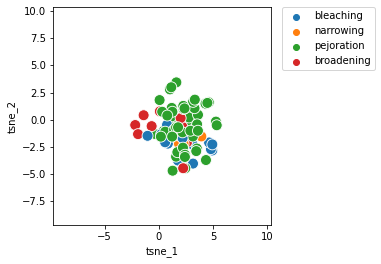

In [ ]:
#@title 50

tsne_result_df = pd.DataFrame({'tsne_1': tsne_df[0], 'tsne_2': tsne_df[1], 'label': tsne_df['type']})
tsne_result_df = tsne_result_df[tsne_result_df['label'].isin(['bleaching', 'narrowing', 'pejoration', 'broadening'])]
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

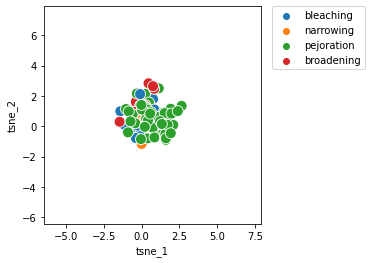

In [ ]:
#@title 100

tsne_result_df = pd.DataFrame({'tsne_1': tsne_df[0], 'tsne_2': tsne_df[1], 'label': tsne_df['type']})
tsne_result_df = tsne_result_df[tsne_result_df['label'].isin(['bleaching', 'narrowing', 'pejoration', 'broadening'])]
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [218]:
df = full_df

### testing correlations

#### correlation notes

takeaways: 
-> is decreasing concreteness, although i really think it's about animacy, and 
up is pejoration, down is amelioration 
 
0 has a mid negative correlation with concreteness. so right-facing arrows indicate decreasing concreteness

1 has a positive correlation with concreteness, so up-facing arrows indicate increasing concreteness

1 has a negative correlation with valence, so up-facing arrows indicate perjoration

1 has a lesser negative correlation with dominance, so up-facing arrows indicate decreasing dominance (maybe related to valence)

1 has a lesser positive corelation with arousal, so up-facing arrows indicate higher arousal

In [ ]:
# let's test and make sure that pc5 is related to valence

# https://saifmohammad.com/WebPages/nrc-vad.html
val_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/NRC-VAD-Lexicon.txt', sep="\t", header=None)
val_df = val_df.rename(columns={0:'Word', 1:'val', 2:'aro', 3:'dom'})[['Word', 'val', 'aro', 'dom']]

conc_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/brysbaert_concreteness.csv')
conc_df = conc_df.rename(columns={'Conc.M': 'conc'})[['Word', 'conc']]

In [188]:
# define how we map a sense to concreteness, valence, arousal values

skip_words = {'the', 'an', 'a', 'of','in', 'it', 'to', 'for', 'on', 'in'} # don't factor these into concreteness

# take all words in the sense and and average values
def senseToValue(s, df, col):
  s = s.lower()
  for i in "(),/":
    s = s.replace(i, "")
  phrases = re.split(' ', s)
  total_val = 0
  val_data = 0
  for p in phrases:
    if p in skip_words:
      continue
    try:
      val = df[df['Word']==p][col].values[0]
      if not np.isnan(val):
        total_val += val
        val_data += 1
    except:
      pass
  if val_data == 0:
    total_val = np.nan
  else:
    total_val /= val_data
  return total_val

In [246]:
# dictionary for concreteness and embeddings
conc_dic = {} # This will be a dictionary that easily allows us to access the concreteness for all of our senses, saving time. 
VAD_dic = {} # This will be a dictionary that easily allows us to access the embedding for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings or concreteness values

for i in range(len(df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  if x not in conc_dic:
    x_conc = senseToValue(x, conc_df, 'conc')
    if not np.isnan(x_conc):
      conc_dic[x] = x_conc
    else:
      error_senses.add(x)

  if y not in conc_dic:
    y_conc = senseToValue(y, conc_df, 'conc')
    if not np.isnan(y_conc):
      conc_dic[y] = y_conc
    else:
      error_senses.add(y)
      
  if x not in VAD_dic:
    if not np.isnan(senseToValue(x, val_df, 'val')):
      VAD_dic[x] = [senseToValue(x, val_df, 'val'), senseToValue(x, val_df, 'aro'), senseToValue(x, val_df, 'dom')]
    else:
      error_senses.add(x)

  if y not in VAD_dic:
    if not np.isnan(senseToValue(y, val_df, 'val')):
      VAD_dic[y] = [senseToValue(y, val_df, 'val'), senseToValue(y, val_df, 'aro'), senseToValue(y, val_df, 'dom')]
    else:
      error_senses.add(x)

In [247]:
vad_averages_df = pd.DataFrame.from_dict(VAD_dic, orient='index').reset_index().rename(columns={'index':'Word'}).rename(columns={0:'val', 1:'aro',2:'dom'})
conc_averages_df = pd.DataFrame.from_dict(conc_dic, orient='index').reset_index().rename(columns={'index':'Word'}).rename(columns={0:'conc'})

In [248]:
df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [df, vad_averages_df])
df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [df, vad_averages_df])
df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [df, conc_averages_df])
df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [df, conc_averages_df])
df['val_diff'] = df['val_y'] - df['val_x']
df['conc_diff'] = df['conc_y'] - df['conc_x']
df['aro_diff'] = df['aro_y'] - df['aro_x']
df['dom_diff'] = df['dom_y'] - df['dom_x']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Word_x'} in the result is deprecated and will raise a MergeError in a future version.
  after removing the cwd from sys.path.


In [252]:
df.corr()[1].sort_values().head(10)

val_y      -4.938356e-01
val_diff   -4.794243e-01
conc_x     -4.275952e-01
dom_y      -3.198496e-01
dom_diff   -2.784409e-01
conc_y     -7.002413e-02
aro_x      -2.049209e-02
3          -1.437609e-07
0          -8.942351e-08
8          -4.109816e-08
Name: 1, dtype: float64